In [3]:
import os
from typing import TypedDict
import time
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from dotenv import load_dotenv
from duckduckgo_search import DDGS

# ╔══════════════════════════════════════════╗
# ║    Complete Research Agent Architecture  ║
# ╚══════════════════════════════════════════╝
#
#           [START]
#              │
#              ▼
#        ┌───────────┐
#        │ classify  │ Analyzes query type
#        └─────┬─────┘ Sets: query_type
#              │
#         ┌────┴────┐
#         │ router()│ Routes to appropriate
#         └────┬────┘ tool based on type
#              │
#     ┌────────┴────────┐
#     ▼                 ▼
# ┌──────────┐    ┌──────────┐
# │calculator│    │  search  │
# │   tool   │    │   tool   │
# │  (math)  │    │  (info)  │
# │    🤖LLM │    │   🔍DDGS │
# └────┬─────┘    └────┬─────┘
#      ▼                ▼
#    [END]            [END]
#
# CONGRATULATIONS! You've built:
# ✅ Query classification
# ✅ Smart routing logic
# ✅ Multiple tool integration
# ✅ Complete AI assistant!
#
# This is a production-ready pattern!

#### Research Agent

In [4]:
class State(TypedDict):
    query: str 
    query_type: str
    result: str

/var/folders/4p/strpkrbd1y782g01xksphyv40000gn/T/ipykernel_34880/3504052810.py:9: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  ddgs = DDGS()


Building research agent graph:



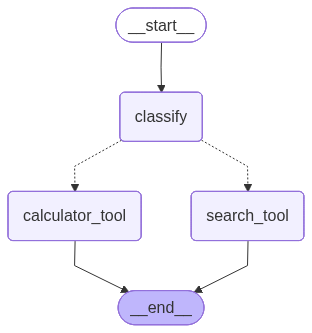

In [8]:
load_dotenv()
llm = ChatOpenAI(
        model="gpt-4.1-mini",
        api_key=os.getenv("OPENAI_API_KEY"),
        base_url=os.getenv("OPENAI_API_BASE"),
        temperature=0.7
    )

ddgs = DDGS()

def classfiy_node(state: State):
    query_lower = state['query'].lower()
    math_keywords = ["+", "-", "*", "/", "plus", "minus", "divided", "calculate", "sum"]
    is_math = any(keyword in query_lower for keyword in math_keywords)

    query_type = 'math' if is_math else "search"

    if query_type == 'math':
        print("Math query detected")
    else:
        print("Search query detected")
    return {"query_type": query_type}

def router(state: State):
    """Route to calculator or general response"""
    if state["query_type"] == "math":
        return "calculator_tool"
    return "search_tool"

def calculator_node(state: State):
    """Uses LLM with calculator tool"""
    print("Invoking calculator tool\n")
    time.sleep(2)

    response = llm.invoke(f"Calculate and return ONLY the answer: {state['query']}")
    answer = response.content.strip()
    print(f"Calculator result: {answer}")

    return {"result": f"Calculation result: {answer}"}

def search_tool(state: State):
    """Web search for information queries""" 
    time.sleep(2)
    try:
        results = ddgs.text(state["query"], max_results=2)

        if results:
            print(f"Found {len(results)} results")
            search_text = "\n".join([f"- {r.get('title', '')}: {r.get('body', '')[:100]}..." for r in results])
            time.sleep(1)
            return {"result": f"Search result:\n{search_text}"}
        
        else:
            print(" ⚠️ No search results found")
            if "langgraph" in state["query"].lower():
                simulated = "Langraph is a framework for building stateful, multi-step AI workflow"
                return {"result": f"Info: {simulated}"}
            
            return {"result": "No search result found"}
        
    except Exception as e:
        print(f" ❌ Search error: {str(e)}")

print("Building research agent graph:\n")

workflow = StateGraph(State)

workflow.add_node("classify", classfiy_node)
workflow.add_node("calculator_tool", calculator_node)
workflow.add_node("search_tool", search_tool)

workflow.set_entry_point("classify")
workflow.add_conditional_edges(
    "classify",
    router,
    {
        "calculator_tool": "calculator_tool",
        "search_tool": "search_tool"
    }
)

workflow.add_edge("calculator_tool", END)
workflow.add_edge("search_tool", END)

workflow.compile()